In [1]:
# --- Blok A: imports & config ---
from __future__ import annotations
from pathlib import Path
import json, functools, math
import numpy as np
import pandas as pd
import soundfile as sf
import librosa, librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio, display

from scipy import signal
import ipywidgets as widgets

# Consistente stijl
plt.rcParams["figure.dpi"] = 120

# Dataset-root
DATA_ROOT = Path("../data").resolve()

# Verwacht: twee taken en twee microfoonlabels
TASKS = ["coughing", "heartsounds"]
MICS  = ["new_microphone", "old_microphone"]

# Segment & audio-constanten uit jouw beschrijving
SEG_DUR = 3.0      # seconden
SR_FIXED = 15750   # Hz (altijd 15750 volgens .json)

# STFT / Mel default
N_FFT = 1024
HOP   = 256
WIN   = "hann"
N_MELS = 128

In [2]:
# --- Blok B: scan .wav + .json en bouw dataframes ---

def find_wavs_and_jsons(root: Path) -> pd.DataFrame:
    """
    Return a DataFrame met één rij per .wav-bestand.
    Kolommen: path, relpath, task, mic, json_path
    """
    rows = []
    for task in TASKS:
        for mic in MICS:
            base = root / task / mic
            if not base.is_dir():
                continue
            for wav in sorted(base.rglob("*.wav")):
                js = wav.with_suffix(".json")
                rows.append({
                    "path": str(wav.resolve()),
                    "relpath": str(wav.relative_to(root).as_posix()),
                    "task": task,
                    "mic": mic,
                    "json_path": str(js.resolve()) if js.exists() else None,
                })
    df = pd.DataFrame(rows).sort_values(["task","mic","relpath"]).reset_index(drop=True)
    return df

def read_segments_from_json(json_path: Path) -> list[dict]:
    """
    Lees segmenten uit sidecar .json (exact het formaat uit je voorbeeld).
    Retourneert lijst met dicts: id, t_start, t_end, labels (list[str])
    """
    with open(json_path, "r", encoding="utf-8") as f:
        d = json.load(f)
    segs = d.get("segments", [])
    # Optioneel: sanity-check op vaste segmentduur
    out = []
    for s in segs:
        t0 = float(s["t_start"]); t1 = float(s["t_end"])
        out.append({
            "seg_id": s["id"],
            "t_start": t0,
            "t_end": t1,
            "dur": t1 - t0,
            "labels": list(s.get("labels", [])),
        })
    return out

def build_segments_table(df_files: pd.DataFrame) -> pd.DataFrame:
    """
    Bouw een tabel met één rij per segment.
    Kolommen: path, relpath, task, mic, seg_id, t_start, t_end, dur, labels
    """
    rows = []
    for _, r in df_files.iterrows():
        if r["json_path"] is None:
            continue
        segs = read_segments_from_json(Path(r["json_path"]))
        for s in segs:
            rows.append({
                "path": r["path"],
                "relpath": r["relpath"],
                "task": r["task"],
                "mic": r["mic"],
                "seg_id": s["seg_id"],
                "t_start": s["t_start"],
                "t_end": s["t_end"],
                "dur": s["dur"],
                "labels": s["labels"],
            })
    df = pd.DataFrame(rows)
    if not df.empty:
        df = df.sort_values(["task","mic","relpath","t_start"]).reset_index(drop=True)
    return df


In [3]:
# Uitvoeren
df_files = find_wavs_and_jsons(DATA_ROOT)
print(f"Aantal .wav-bestanden: {len(df_files)}")
display(df_files.head(3))

Aantal .wav-bestanden: 40


,path,relpath,task,mic,json_path
0,C:\Users\MSI\Documents\Persoonlijke Projecten\...,coughing/new_microphone/cough_1.wav,coughing,new_microphone,C:\Users\MSI\Documents\Persoonlijke Projecten\...
1,C:\Users\MSI\Documents\Persoonlijke Projecten\...,coughing/new_microphone/cough_2.wav,coughing,new_microphone,C:\Users\MSI\Documents\Persoonlijke Projecten\...
2,C:\Users\MSI\Documents\Persoonlijke Projecten\...,coughing/new_microphone/cough_3.wav,coughing,new_microphone,C:\Users\MSI\Documents\Persoonlijke Projecten\...


In [4]:
# Uitvoeren
df_segs  = build_segments_table(df_files)
print(f"Aantal segmenten: {len(df_segs)}")
display(df_segs.head(5))

Aantal segmenten: 369


,path,relpath,task,mic,seg_id,t_start,t_end,dur,labels
0,C:\Users\MSI\Documents\Persoonlijke Projecten\...,coughing/new_microphone/cough_1.wav,coughing,new_microphone,dae77b6c-e8e4-43cc-baaf-b56cf1bd01ef,1.68,4.68,3.0,[Hoest]
1,C:\Users\MSI\Documents\Persoonlijke Projecten\...,coughing/new_microphone/cough_1.wav,coughing,new_microphone,de8a067b-e2d6-4660-8589-189294866f25,6.80,9.80,3.0,[Hoest]
2,C:\Users\MSI\Documents\Persoonlijke Projecten\...,coughing/new_microphone/cough_1.wav,coughing,new_microphone,9d213259-75ac-428e-83e2-10dbe74a88e3,11.93,14.93,3.0,[Hoest]
3,C:\Users\MSI\Documents\Persoonlijke Projecten\...,coughing/new_microphone/cough_1.wav,coughing,new_microphone,c2b67ec8-0263-4b8a-be39-088835a9678f,16.77,19.77,3.0,[Hoest]
4,C:\Users\MSI\Documents\Persoonlijke Projecten\...,coughing/new_microphone/cough_1.wav,coughing,new_microphone,e712c1eb-c012-4b39-bf22-b9c94126352d,21.38,24.38,3.0,[Hoest]


In [5]:
# Toon 3 rijen met [Hoest], 3 rijen met [Hart] en 3 rijen met [Normaal]
rows_cough = df_segs[df_segs["labels"].apply(lambda x: "Hoest" in x)].head(3)
display(rows_cough)
row_normal = df_segs[df_segs["labels"].apply(lambda x: "Normaal" in x)].head(3)
display(row_normal)
rows_heart = df_segs[df_segs["labels"].apply(lambda x: "Hart" in x)].head(3)
display(rows_heart)

,path,relpath,task,mic,seg_id,t_start,t_end,dur,labels
0,C:\Users\MSI\Documents\Persoonlijke Projecten\...,coughing/new_microphone/cough_1.wav,coughing,new_microphone,dae77b6c-e8e4-43cc-baaf-b56cf1bd01ef,1.68,4.68,3.0,[Hoest]
1,C:\Users\MSI\Documents\Persoonlijke Projecten\...,coughing/new_microphone/cough_1.wav,coughing,new_microphone,de8a067b-e2d6-4660-8589-189294866f25,6.80,9.80,3.0,[Hoest]
2,C:\Users\MSI\Documents\Persoonlijke Projecten\...,coughing/new_microphone/cough_1.wav,coughing,new_microphone,9d213259-75ac-428e-83e2-10dbe74a88e3,11.93,14.93,3.0,[Hoest]


,path,relpath,task,mic,seg_id,t_start,t_end,dur,labels
8,C:\Users\MSI\Documents\Persoonlijke Projecten\...,coughing/new_microphone/cough_2.wav,coughing,new_microphone,f9d5cbe6-12ef-4a3b-b059-a338c41af2d9,10.96,13.96,3.0,[Normaal]
11,C:\Users\MSI\Documents\Persoonlijke Projecten\...,coughing/new_microphone/cough_2.wav,coughing,new_microphone,698a3e61-304a-407b-90b4-2fd4cde92581,23.60,26.60,3.0,[Normaal]
30,C:\Users\MSI\Documents\Persoonlijke Projecten\...,coughing/new_microphone/normal_1.wav,coughing,new_microphone,03369a89-c33c-4638-9dcd-8fe11c40c0b2,0.00,3.00,3.0,[Normaal]


,path,relpath,task,mic,seg_id,t_start,t_end,dur,labels
169,C:\Users\MSI\Documents\Persoonlijke Projecten\...,heartsounds/new_microphone/T13_30_15_D25_09_20...,heartsounds,new_microphone,0790c1dc-ac1b-4f20-aec0-ff2fefad9d03,0.0,3.0,3.0,[Hart]
170,C:\Users\MSI\Documents\Persoonlijke Projecten\...,heartsounds/new_microphone/T13_30_15_D25_09_20...,heartsounds,new_microphone,7e50cbee-40e2-451b-9223-4496bbbe5dc3,3.0,6.0,3.0,[Hart]
171,C:\Users\MSI\Documents\Persoonlijke Projecten\...,heartsounds/new_microphone/T13_30_15_D25_09_20...,heartsounds,new_microphone,6eefbd0a-7e21-4c05-afab-95597d401644,6.0,9.0,3.0,[Hart]


In [6]:
# --- Blok C: helpers voor audio, filtering en spectrogrammen ---

@functools.lru_cache(maxsize=1024)
def load_audio_cached(wav_path: str) -> tuple[np.ndarray, int]:
    """
    Load mono audio en sample rate direct vanaf disk.
    Houdt originele sample rate aan (verwacht 15750 Hz).
    """
    y, sr = sf.read(wav_path, dtype="float32", always_2d=False)
    if y.ndim == 2:
        y = y.mean(axis=1)
    return y.astype(np.float32), int(sr)

def slice_seconds(y: np.ndarray, sr: int, t0: float, t1: float) -> np.ndarray:
    """Pak y[t0:t1] in seconden; clamp aan grenzen."""
    a = max(0, int(round(t0 * sr)))
    b = min(len(y), int(round(t1 * sr)))
    return y[a:b]

def bandpass_filter(y: np.ndarray, fs: int, fc=(50.0, 2000.0), order=4, zero_phase=True) -> np.ndarray:
    """
    Butterworth bandpass. zero_phase=True gebruikt filtfilt (symmetrisch, geen faseverschuiving).
    """
    low, high = fc
    # Bescherm tegen te hoge high cutoff
    high = min(high, fs/2 - 1.0)
    sos = signal.butter(order, [low, high], btype="bandpass", fs=fs, output="sos")
    if zero_phase:
        return signal.sosfiltfilt(sos, y).astype(np.float32)
    return signal.sosfilt(sos, y).astype(np.float32)

def stft_db(y: np.ndarray, sr: int, n_fft=N_FFT, hop_length=HOP, win=WIN) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """STFT -> dB + tijd- en frequentie-assen."""
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window=win, center=True)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    times = librosa.frames_to_time(np.arange(S_db.shape[1]), sr=sr, hop_length=hop_length, n_fft=n_fft)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    return S_db, times, freqs

def mel_db(y: np.ndarray, sr: int, n_fft=N_FFT, hop_length=HOP, n_mels=N_MELS) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Mel-spectrogram in dB + assen."""
    M = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, power=2.0)
    M_db = librosa.power_to_db(M, ref=np.max)
    times = librosa.frames_to_time(np.arange(M_db.shape[1]), sr=sr, hop_length=hop_length, n_fft=n_fft)
    freqs = librosa.mel_frequencies(n_mels=M_db.shape[0], fmin=0.0, fmax=sr/2.0)
    return M_db, times, freqs

C:\Users\MSI\AppData\Local\Temp\ipykernel_137656\1082248866.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


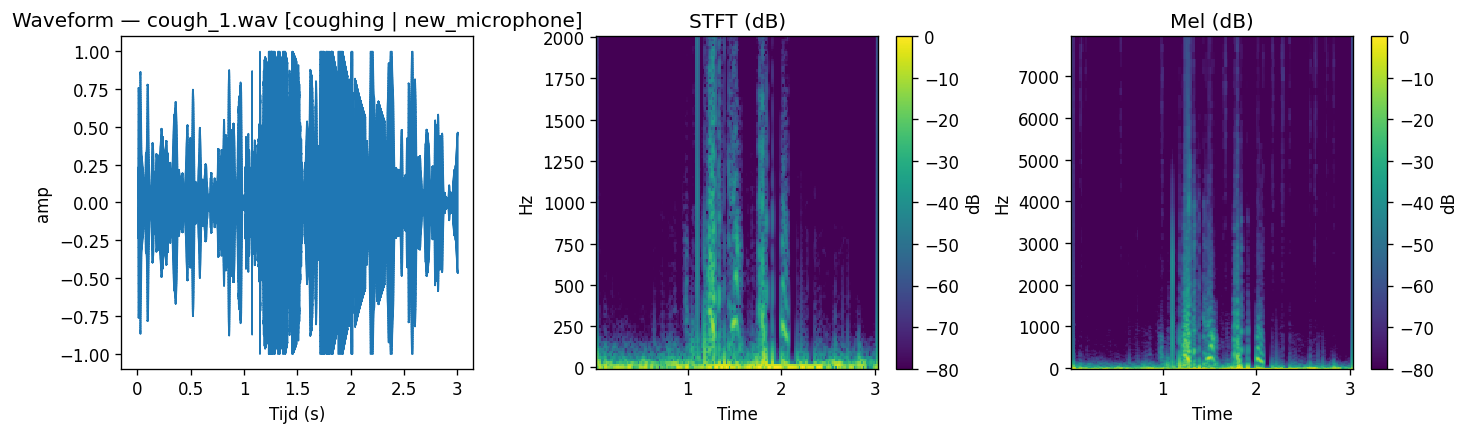

In [7]:
# --- Blok D: eenvoudige plothelpers ---

def plot_triplet(y: np.ndarray, sr: int, title_prefix: str, fmax=None):
    """
    Plot waveform, STFT(dB) en Mel(dB) naast elkaar.
    fmax: optioneel bovengrens voor frequentie-as STFT.
    """
    fig = plt.figure(figsize=(14, 3.6))
    gs = fig.add_gridspec(1, 3, wspace=0.35)

    # 1) Waveform
    ax0 = fig.add_subplot(gs[0, 0])
    librosa.display.waveshow(y, sr=sr, ax=ax0)
    ax0.set_title(f"Waveform — {title_prefix}")
    ax0.set_xlabel("Tijd (s)"); ax0.set_ylabel("amp")

    # 2) STFT
    ax1 = fig.add_subplot(gs[0, 1])
    S_db, tS, fS = stft_db(y, sr)
    if fmax is None: fmax = sr/2.0
    mask = fS <= fmax
    im1 = ax1.pcolormesh(tS, fS[mask], S_db[mask, :], shading="auto")
    ax1.set_title("STFT (dB)"); ax1.set_xlabel("Time"); ax1.set_ylabel("Hz")
    cb1 = fig.colorbar(im1, ax=ax1); cb1.set_label("dB")

    # 3) Mel
    ax2 = fig.add_subplot(gs[0, 2])
    M_db, tM, fM = mel_db(y, sr)
    im2 = ax2.pcolormesh(tM, fM, M_db, shading="auto")
    ax2.set_title("Mel (dB)"); ax2.set_xlabel("Time"); ax2.set_ylabel("Hz")
    cb2 = fig.colorbar(im2, ax=ax2); cb2.set_label("dB")

    plt.tight_layout()
    plt.show()

# --- Voorbeeld: eerste segment van het eerste bestand (indien aanwezig) ---
if len(df_segs):
    r0 = df_segs.iloc[0]
    y, sr = load_audio_cached(r0["path"])
    y_seg = slice_seconds(y, sr, r0["t_start"], r0["t_end"])
    title = f"{Path(r0['path']).name} [{r0['task']} | {r0['mic']}]"
    plot_triplet(y_seg, sr, title_prefix=title, fmax=2000.0)
    display(Audio(y_seg, rate=sr))
else:
    print("Geen segmenten gevonden.")

In [8]:
# --- Blok E: interactieve viewer + playback met optionele bandpass ---

# Widget-config
n_fft = N_FFT
hop_length = HOP
win = WIN

idx_slider   = widgets.IntSlider(value=0, min=0, max=max(0, len(df_files)-1), step=1, description='Index:')
use_filter   = widgets.Checkbox(value=False, description='Bandpass aan')
low_box      = widgets.FloatText(value=50.0, description='Low (Hz):', step=1.0)
high_box     = widgets.FloatText(value=2000.0, description='High (Hz):', step=1.0)
order_slider = widgets.IntSlider(value=4, min=1, max=12, step=1, description='Order:')
zero_chk     = widgets.Checkbox(value=True, description='Zero-phase')

ui_left  = widgets.VBox([idx_slider, use_filter, low_box, high_box, order_slider, zero_chk])
out_area = widgets.Output()

def _update(idx, use_filter, low, high, order, zero_phase):
    with out_area:
        out_area.clear_output(wait=True)

        # Bestand kiezen
        row = df_files.iloc[int(idx)]
        wav_file = row["path"]
        task_lbl = row.get("task", "unknown")
        mic_lbl  = row.get("mic",  "unknown")
        title_suffix = f"[{task_lbl} | {mic_lbl}]"

        # Audio laden (cached)
        y, sr = load_audio_cached(wav_file)

        # Optioneel filteren (we tonen/plays 'y_view'; ruwe data blijven ongewijzigd)
        y_view = y
        if use_filter:
            high_eff = min(float(high), sr/2 - 1.0)
            if high_eff <= float(low):
                high_eff = min(float(low) + 10.0, sr/2 - 1.0)
            y_view = bandpass_filter(y_view, fs=sr, fc=(float(low), high_eff),
                                     order=int(order), zero_phase=bool(zero_phase))
            fmax_plot = high_eff
        else:
            fmax_plot = sr / 2.0

        # 1) Waveform
        plt.figure(figsize=(12, 3))
        librosa.display.waveshow(y_view, sr=sr)
        plt.title(f"Waveform — {Path(wav_file).name} {title_suffix}")
        plt.xlabel("Tijd (s)"); plt.ylabel("Amplitude")
        plt.tight_layout(); plt.show()

        # 2) STFT
        S = librosa.stft(y_view, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window=win, center=True)
        S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
        times = librosa.frames_to_time(np.arange(S_db.shape[1]), sr=sr, hop_length=hop_length, n_fft=n_fft)
        freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

        mask = freqs <= fmax_plot
        if not np.any(mask):
            mask = freqs <= (sr/2.0)
        freqs_plot = freqs[mask]
        S_db_plot  = S_db[mask, :]

        plt.figure(figsize=(12, 4))
        plt.pcolormesh(times, freqs_plot, S_db_plot, shading="auto")
        plt.title(f"STFT — {Path(wav_file).name} {title_suffix}")
        plt.xlabel("Tijd (s)"); plt.ylabel("Frequentie (Hz)")
        cbar = plt.colorbar(); cbar.set_label("Amplitude (dB)")
        plt.ylim(0.0, fmax_plot)
        plt.tight_layout(); plt.show()

        # 3) Audio player (volledige clip)
        display(Audio(y_view, rate=sr))

controls = {
    'idx': idx_slider,
    'use_filter': use_filter,
    'low': low_box,
    'high': high_box,
    'order': order_slider,
    'zero_phase': zero_chk,
}
linked_out = widgets.interactive_output(_update, controls)
display(widgets.HBox([ui_left, out_area]))

# Eerste render
if len(df_files):
    _update(idx_slider.value, use_filter.value, low_box.value, high_box.value, order_slider.value, zero_chk.value)
else:
    with out_area:
        print("Geen audio-bestanden gevonden in df_files.")


C:\Users\MSI\AppData\Local\Temp\ipykernel_137656\1082248866.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


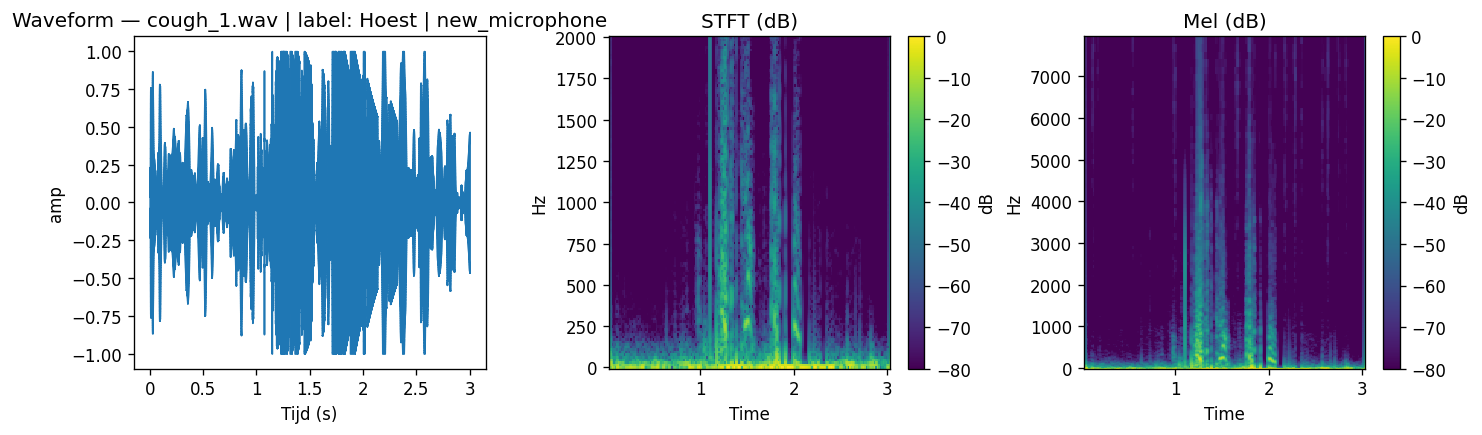

C:\Users\MSI\AppData\Local\Temp\ipykernel_137656\1082248866.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


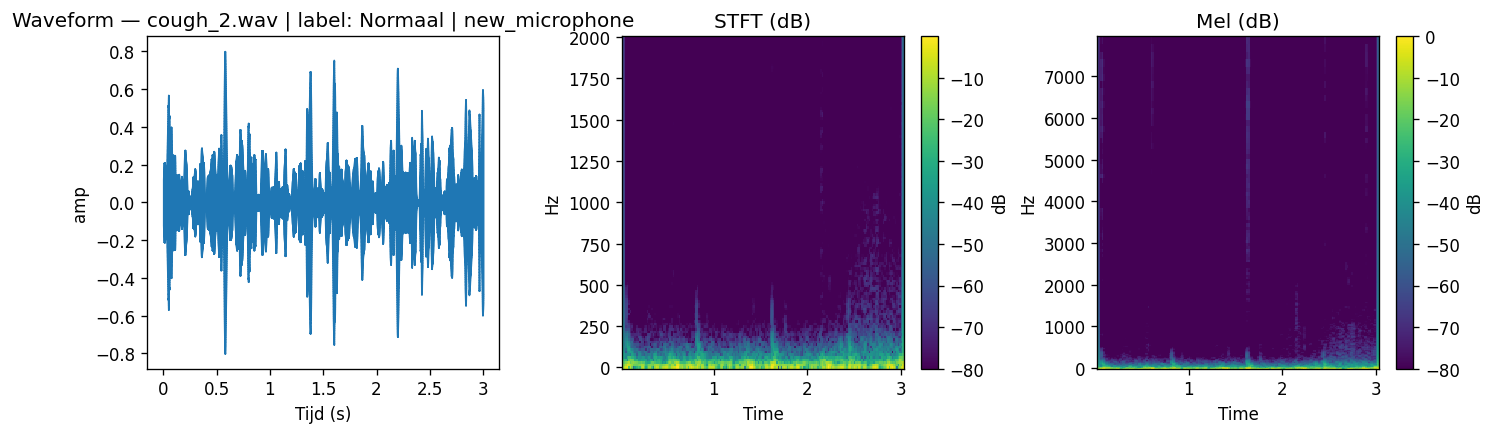

C:\Users\MSI\AppData\Local\Temp\ipykernel_137656\1082248866.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


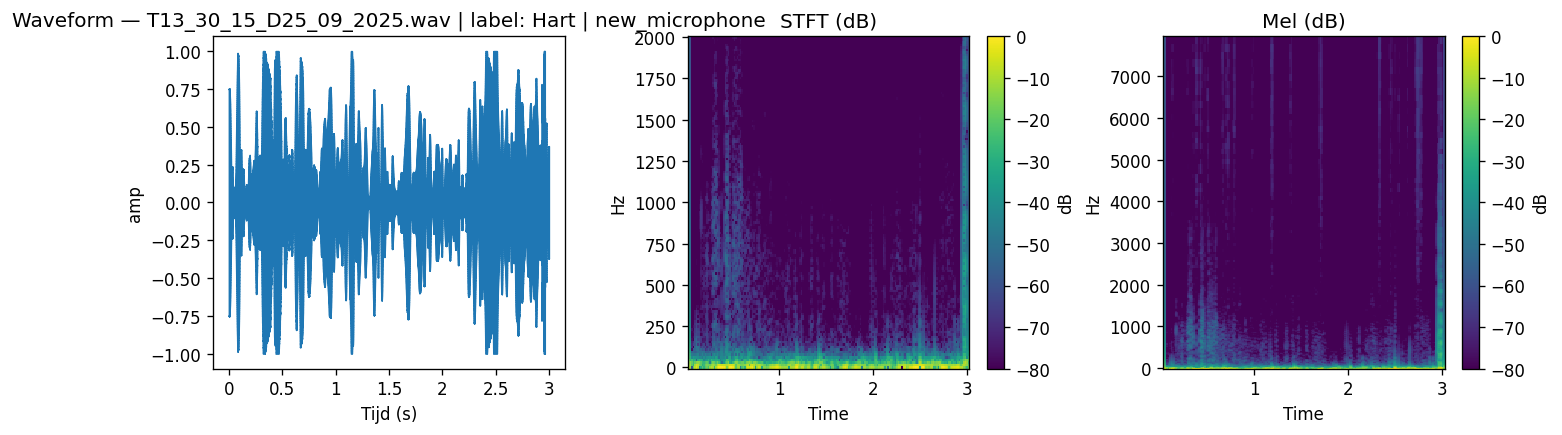

In [9]:
def show_segment(row_seg: pd.Series, apply_filter=False, low=50.0, high=2000.0, order=4, zero_phase=True):
    y, sr = load_audio_cached(row_seg["path"])
    y_seg = slice_seconds(y, sr, row_seg["t_start"], row_seg["t_end"])
    if apply_filter:
        y_seg = bandpass_filter(y_seg, fs=sr, fc=(low, min(high, sr/2-1.0)), order=order, zero_phase=zero_phase)
    label = ", ".join(row_seg["labels"])
    title = f"{Path(row_seg['path']).name} | label: {label} | {row_seg['mic']}"
    plot_triplet(y_seg, sr, title_prefix=title, fmax=min(high, sr/2.0) if apply_filter else 2000.0)
    display(Audio(y_seg, rate=sr))

# Plot één segment van elk type: coughing, normal, heartsounds

row_cough = df_segs[df_segs["labels"].apply(lambda x: "Hoest" in x)].iloc[0]
show_segment(row_cough, apply_filter=False)

row_normal = df_segs[df_segs["labels"].apply(lambda x: "Normaal" in x)].iloc[0]
show_segment(row_normal, apply_filter=False)

row_heart = df_segs[df_segs["labels"].apply(lambda x: "Hart" in x)].iloc[0]
show_segment(row_heart, apply_filter=False)
